In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# read in data
data = pd.read_csv('../data/phishing_email.csv')

# Split into train and test sets
X = data["text_combined"]
Y = data["label"]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.2,
    stratify=Y,
    random_state=42
)

print("Training data shape: ", X_train.shape)
print("Testing data shape: ", X_test.shape)

Training data shape:  (65988,)
Testing data shape:  (16498,)


In [3]:
# define the Multinomial Naive Bayes model
nb = MultinomialNB(
    alpha=1.0 
)

# define the TF-IDF vectorizer
tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=5,
    max_df=0.9
)

In [5]:
# create pipeline
pipeline = Pipeline([
    ("tfidf", tfidf),
    ("clf", nb)
])

# train model
pipeline.fit(X_train, Y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [ ]:
# make predictions on test data
Y_pred = pipeline.predict(X_test)
Y_proba = pipeline.predict_proba(X_test)[:, 1]

In [7]:
print(Y_pred)
print(Y_proba)

[1 0 1 ... 1 0 0]
[9.98164972e-01 1.07638802e-05 9.44946167e-01 ... 9.22421314e-01
 2.44107210e-07 1.51296670e-08]


In [10]:
# get metrics
print(classification_report(Y_test, Y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(Y_test, Y_proba))

              precision    recall  f1-score   support

           0     0.9513    0.9859    0.9683      7919
           1     0.9865    0.9534    0.9697      8579

    accuracy                         0.9690     16498
   macro avg     0.9689    0.9696    0.9690     16498
weighted avg     0.9696    0.9690    0.9690     16498

ROC-AUC: 0.9969868746680844


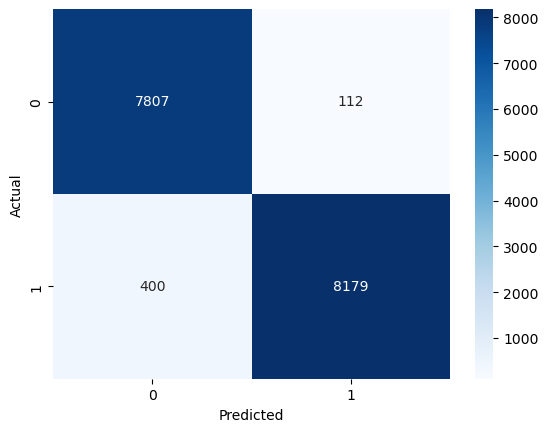

In [11]:
# generate confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [12]:
# tuning alpha hyperparameter
from sklearn.model_selection import GridSearchCV

param_grid = {
    "clf__alpha": [0.01, 0.1, 0.5, 1.0, 2.0]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, Y_train)

print("Best alpha:", grid.best_params_)

KeyboardInterrupt: 

In [15]:
# Most informative n-grams
feature_names = pipeline.named_steps["tfidf"].get_feature_names_out()
log_probs = pipeline.named_steps["clf"].feature_log_prob_

# Class 1 = spam
top_spam = sorted(
    zip(feature_names, log_probs[1]),
    key=lambda x: x[1],
    reverse=True
)[:20]

# Class 0 = legitimate
top_legit = sorted(
    zip(feature_names, log_probs[0]),
    key=lambda x: x[1],
    reverse=True
)[:20]

print("Top 20 n-grams indicative of spam:")
for feature, coef in top_spam:
    print(f"{feature}: {coef:.4f}")

print("\nTop 20 n-grams indicative of legitimate emails:")
for feature, coef in top_legit:
    print(f"{feature}: {coef:.4f}")

Top 20 n-grams indicative of spam:
ed : -8.1323
cnn: -8.1368
com: -8.1687
ing: -8.2308
 re: -8.2414
er : -8.2943
 co: -8.2943
ng : -8.3483
ion: -8.3642
es : -8.4092
ing : -8.4138
ent: -8.4555
on : -8.4849
nt : -8.4995
 pr: -8.5203
om : -8.5227
nncom: -8.5441
cnnco: -8.5441
cnnc: -8.5445
nnco: -8.5446

Top 20 n-grams indicative of legitimate emails:
___: -6.9253
____: -6.9477
_____: -6.9709
ing: -7.9660
ng : -8.0147
ing : -8.0551
on : -8.0719
ed : -8.0859
ion: -8.1439
 co: -8.1640
tio: -8.2863
tion: -8.2870
es : -8.2891
 re: -8.3094
er : -8.3258
ent: -8.4293
ion : -8.4556
nt : -8.5287
ati: -8.5747
tion : -8.5902


In [16]:
import joblib

joblib.dump(pipeline, "../models/nb_phishing_model.joblib")

['../models/nb_phishing_model.joblib']